from https://pyro.ai/examples/normalizing_flows_i.html

# Normalizing Flows - Introduction (Part 1)

This tutorial introduces Pyro's normalizing flow library. It is independent of much of Pyro, but users may want to read about distribution shapes in the [Tensor Shapes Tutorial](http://pyro.ai/examples/tensor_shapes.html).
 
## Introduction

In standard probabilistic modeling practice, we represent our beliefs over unknown continuous quantities with simple parametric distributions like the normal, exponential, and Laplacian distributions. However, using such simple forms, which are commonly symmetric and unimodal (or have a fixed number of modes when we take a mixture of them), restricts the performance and flexibility of our methods. For instance, standard variational inference in the Variational Autoencoder uses independent univariate normal distributions to represent the variational family. The true posterior is neither independent nor normally distributed, which results in suboptimal inference and simplifies the model that is learnt. In other scenarios, we are likewise restricted by not being able to model multimodal distributions and heavy or light tails.

Normalizing Flows \[1-4\] are a family of methods for constructing flexible learnable probability distributions, often with neural networks, which allow us to surpass the limitations of simple parametric forms. Pyro contains state-of-the-art normalizing flow implementations, and this tutorial explains how you can use this library for learning complex models and performing flexible variational inference. We introduce the main idea of Normalizing Flows (NFs) and demonstrate learning simple univariate distributions with element-wise, multivariate, and conditional flows.

## Univariate Distributions
 
### Background
 
Normalizing Flows are a family of methods for constructing flexible distributions. Let's first restrict our attention to representing univariate distributions. The basic idea is that a simple source of noise, for example a variable with a standard normal distribution, $X\sim\mathcal{N}(0,1)$, is passed through a bijective (i.e. invertible) function, $g(\cdot)$ to produce a more complex transformed variable $Y=g(X)$.

For a given random variable, we typically want to perform two operations: sampling and scoring. Sampling $Y$ is trivial. First, we sample $X=x$, then calculate $y=g(x)$. Scoring $Y$, or rather, evaluating the log-density $\log(p_Y(y))$, is more involved. How does the density of $Y$ relate to the density of $X$? We can use the substitution rule of integral calculus to answer this. Suppose we want to evaluate the expectation of some function of $X$. Then,

$$
\begin{align}
     \mathbb{E}_{p_X(\cdot)}\left[f(X)\right] &= \int_{\text{supp}(X)}f(x)p_X(x)dx\\
     &= \int_{\text{supp}(Y)}f(g^{-1}(y))p_X(g^{-1}(y))\left|\frac{dx}{dy}\right|dy\\
     &= \mathbb{E}_{p_Y(\cdot)}\left[f(g^{-1}(Y))\right],
\end{align}
$$

where $\text{supp}(X)$ denotes the support of $X$, which in this case is $(-\infty,\infty)$. Crucially, we used the fact that $g$ is bijective to apply the substitution rule in going from the first to the second line. Equating the last two lines we get,

$$
\begin{align}
     \log(p_Y(y)) &= \log(p_X(g^{-1}(y)))+\log\left(\left|\frac{dx}{dy}\right|\right)\\
     &= \log(p_X(g^{-1}(y)))-\log\left(\left|\frac{dy}{dx}\right|\right).
\end{align}
$$

Inituitively, this equation says that the density of $Y$ is equal to the density at the corresponding point in $X$ plus a term that corrects for the warp in volume around an infinitesimally small length around $Y$ caused by the transformation.

If $g$ is cleverly constructed (and we will see several examples shortly), we can produce distributions that are more complex than standard normal noise and yet have easy sampling and computationally tractable scoring. Moreover, we can compose such bijective transformations to produce even more complex distributions. By an inductive argument, if we have $L$ transforms $g_{(0)}, g_{(1)},\ldots,g_{(L-1)}$, then the log-density of the transformed variable $Y=(g_{(0)}\circ g_{(1)}\circ\cdots\circ g_{(L-1)})(X)$ is

$$
\begin{align}
     \log(p_Y(y)) &= \log\left(p_X\left(\left(g_{(L-1)}^{-1}\circ\cdots\circ g_{(0)}^{-1}\right)\left(y\right)\right)\right)+\sum^{L-1}_{l=0}\log\left(\left|\frac{dg^{-1}_{(l)}(y_{(l)})}{dy'}\right|\right),
     %\left( g^{(l)}(y^{(l)})
     %\right).
\end{align}
$$

where we've defined $y_{(0)}=x$, $y_{(L-1)}=y$ for convenience of notation.

In a latter section, we will see how to generalize this method to multivariate $X$. The field of Normalizing Flows aims to construct such $g$ for multivariate $X$ to transform simple i.i.d. standard normal noise into complex, learnable, high-dimensional distributions. The methods have been applied to such diverse applications as image modeling, text-to-speech, unsupervised language induction, data compression, and modeling molecular structures. As probability distributions are the most fundamental component of probabilistic modeling we will likely see many more exciting state-of-the-art applications in the near future.

### Fixed Univariate Transforms in Pyro

PyTorch contains classes for representing *fixed* univariate bijective transformations, and sampling/scoring from transformed distributions derived from these. Pyro extends this with a comprehensive library of *learnable* univariate and multivariate transformations using the latest developments in the field. As Pyro imports all of PyTorch's distributions and transformations, we will work solely with Pyro. We also note that the NF components in Pyro can be used independently of the probabilistic programming functionality of Pyro, which is what we will be doing in the first two tutorials.

Let us begin by showing how to represent and manipulate a simple transformed distribution,

$$
\begin{align}
 X &\sim \mathcal{N}(0,1)\\
 Y &= \text{exp}(X).
\end{align}
$$

You may have recognized that this is by definition, $Y\sim\text{LogNormal}(0,1)$.

We begin by importing the relevant libraries:

In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)

A variety of bijective transformations live in the [pyro.distributions.transforms](http://docs.pyro.ai/en/stable/distributions.html#transforms) module, and the classes to define transformed distributions live in [pyro.distributions](http://docs.pyro.ai/en/stable/distributions.html). We first create the base distribution of $X$ and the class encapsulating the transform $\text{exp}(\cdot)$:

In [2]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
exp_transform = T.ExpTransform()

The class [ExpTransform](https://pytorch.org/docs/master/distributions.html#torch.distributions.transforms.ExpTransform) derives from [Transform](https://pytorch.org/docs/master/distributions.html#torch.distributions.transforms.Transform) and defines the forward, inverse, and log-absolute-derivative operations for this transform,

$$
\begin{align}
     g(x) &= \text{exp(x)}\\
     g^{-1}(y) &= \log(y)\\
     \log\left(\left|\frac{dg}{dx}\right|\right) &= y.
\end{align}
$$

In general, a transform class defines these three operations, from which it is sufficient to perform sampling and scoring.

The class [TransformedDistribution](https://pytorch.org/docs/master/distributions.html#torch.distributions.transformed_distribution.TransformedDistribution) takes a base distribution of simple noise and a list of transforms, and encapsulates the distribution formed by applying these transformations in sequence. We use it as:

In [3]:
dist_y = dist.TransformedDistribution(dist_x, [exp_transform])

Now, plotting samples from both to verify that we that have produced the log-normal distribution:

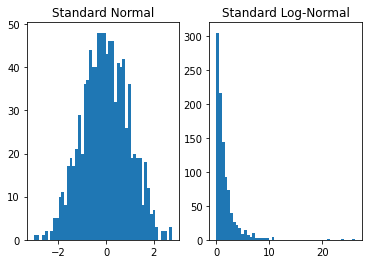

In [4]:
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Standard Log-Normal')
plt.show()

Our example uses a single transform. However, we can compose transforms to produce more expressive distributions. For instance, if we apply an affine transformation we can produce the general log-normal distribution,

$$
\begin{align}
 X &\sim \mathcal{N}(0,1)\\
 Y &= \text{exp}(\mu+\sigma X).
\end{align}
$$

or rather, $Y\sim\text{LogNormal}(\mu,\sigma^2)$. In Pyro this is accomplished, e.g. for $\mu=3, \sigma=0.5$, as follows:

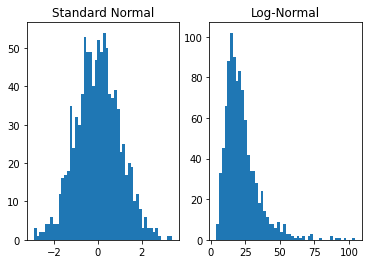

In [5]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()

For the forward operation, transformations are applied in the order of the list that is the second argument to [TransformedDistribution](https://pytorch.org/docs/master/distributions.html#torch.distributions.transformed_distribution.TransformedDistribution). In this case, first [AffineTransform](https://pytorch.org/docs/master/distributions.html#torch.distributions.transforms.AffineTransform) is applied to the base distribution and then [ExpTransform](https://pytorch.org/docs/master/distributions.html#torch.distributions.transforms.ExpTransform).

### Learnable Univariate Distributions in Pyro

Having introduced the interface for invertible transforms and transformed distributions, we now show how to represent *learnable* transforms and use them for density estimation. Our dataset in this section and the next will comprise samples along two concentric circles. Examining the joint and marginal distributions:

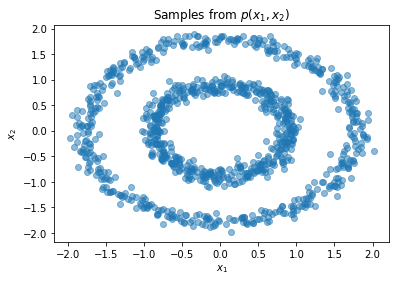

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


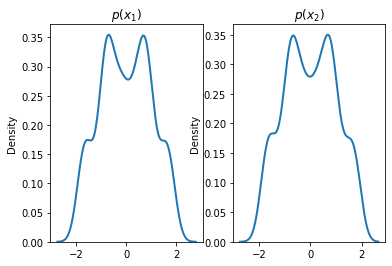

In [13]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True, 
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True, 
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

Standard transforms derive from the [Transform](https://pytorch.org/docs/master/distributions.html#torch.distributions.transforms.ExpTransform) class and are not designed to contain learnable parameters. Learnable transforms, on the other hand, derive from [TransformModule](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.TransformModule), which is a [torch.nn.Module](https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module) and registers parameters with the object.

We will learn the marginals of the above distribution using such a transform, [Spline](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.Spline) \[5,6\], defined on a two-dimensional input:

In [14]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.Spline(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

This transform passes each dimension of its input through a *separate* monotonically increasing function known as a spline. From a high-level, a spline is a complex parametrizable curve for which we can define specific points known as knots that it passes through and the derivatives at the knots. The knots and their derivatives are parameters that can be learnt, e.g., through stochastic gradient descent on a maximum likelihood objective, as we now demonstrate:

In [15]:
%%time
steps = 1001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    
    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.4519453048706055
step: 200, loss: 1.3441768884658813
step: 400, loss: 1.286773681640625
step: 600, loss: 1.2676701545715332
step: 800, loss: 1.263930320739746
step: 1000, loss: 1.261836290359497
CPU times: user 4.27 s, sys: 151 ms, total: 4.42 s
Wall time: 4.73 s


Note that we call `flow_dist.clear_cache()` after each optimization step to clear the transform's forward-inverse cache. This is required because `flow_dist`'s `spline_transform` is a stateful [TransformModule](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.TransformModule) rather than a purely stateless [Transform](https://pytorch.org/docs/stable/distributions.html#torch.distributions.transforms.Transform) object. Purely functional Pyro code typically creates `Transform` objects each model execution, then discards them after `.backward()`, effectively clearing the transform caches. By contrast in this tutorial we create stateful module objects and need to manually clear their cache after update.

Plotting samples drawn from the transformed distribution after learning:

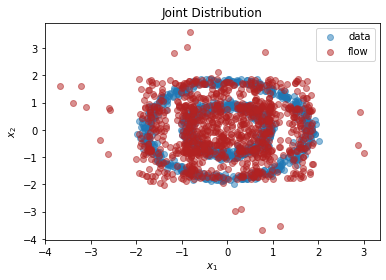

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

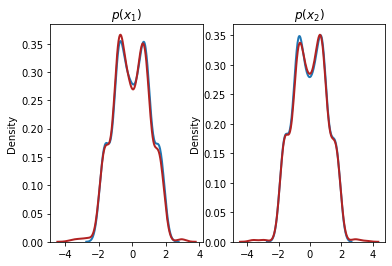

In [16]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True, 
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True, 
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True, 
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True, 
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

As we can see, we have learnt close approximations to the marginal distributions, $p(x_1),p(x_2)$. It would have been challenging to fit the irregularly shaped marginals with standard methods, e.g., a mixture of normal distributions. As expected, since there is a dependency between the two dimensions, we do not learn a good representation of the joint, $p(x_1,x_2)$. In the next section, we explain how to learn multivariate distributions whose dimensions are not independent.

## Multivariate Distributions

### Background

The fundamental idea of normalizing flows also applies to multivariate random variables, and this is where its value is clearly seen - *representing complex high-dimensional distributions*. In this case, a simple multivariate source of noise, for example a standard i.i.d. normal distribution, $X\sim\mathcal{N}(\mathbf{0},I_{D\times D})$, is passed through a vector-valued bijection, $g:\mathbb{R}^D\rightarrow\mathbb{R}^D$, to produce the more complex transformed variable $Y=g(X)$.

Sampling $Y$ is again trivial and involves evaluation of the forward pass of $g$. We can score $Y$ using the multivariate substitution rule of integral calculus,

$$
\begin{align}
     \mathbb{E}_{p_X(\cdot)}\left[f(X)\right] &= \int_{\text{supp}(X)}f(\mathbf{x})p_X(\mathbf{x})d\mathbf{x}\\
     &= \int_{\text{supp}(Y)}f(g^{-1}(\mathbf{y}))p_X(g^{-1}(\mathbf{y}))\det\left|\frac{d\mathbf{x}}{d\mathbf{y}}\right|d\mathbf{y}\\
     &= \mathbb{E}_{p_Y(\cdot)}\left[f(g^{-1}(Y))\right],
 \end{align}
$$

where $d\mathbf{x}/d\mathbf{y}$ denotes the Jacobian matrix of $g^{-1}(\mathbf{y})$. Equating the last two lines we get,

$$
\begin{align}
     \log(p_Y(y)) &= \log(p_X(g^{-1}(y)))+\log\left(\det\left|\frac{d\mathbf{x}}{d\mathbf{y}}\right|\right)\\
     &= \log(p_X(g^{-1}(y)))-\log\left(\det\left|\frac{d\mathbf{y}}{d\mathbf{x}}\right|\right).
\end{align}
$$

Inituitively, this equation says that the density of $Y$ is equal to the density at the corresponding point in $X$ plus a term that corrects for the warp in volume around an infinitesimally small volume around $Y$ caused by the transformation. For instance, in $2$-dimensions, the geometric interpretation of the absolute value of the determinant of a Jacobian is that it represents the area of a parallelogram with edges defined by the columns of the Jacobian. In $n$-dimensions, the geometric interpretation of the absolute value of the determinant Jacobian is that is represents the hyper-volume of a parallelepiped with $n$ edges defined by the columns of the Jacobian (see a calculus reference such as \[7\] for more details).

Similar to the univariate case, we can compose such bijective transformations to produce even more complex distributions. By an inductive argument, if we have $L$ transforms $g_{(0)}, g_{(1)},\ldots,g_{(L-1)}$, then the log-density of the transformed variable $Y=(g_{(0)}\circ g_{(1)}\circ\cdots\circ g_{(L-1)})(X)$ is

$$
\begin{align}
     \log(p_Y(y)) &= \log\left(p_X\left(\left(g_{(L-1)}^{-1}\circ\cdots\circ g_{(0)}^{-1}\right)\left(y\right)\right)\right)+\sum^{L-1}_{l=0}\log\left(\left\vert\frac{dg^{-1}_{(l)}(y_{(l)})}{dy'}\right|\right),
     %\left( g^{(l)}(y^{(l)})
     %\right).
\end{align}
$$

where we've defined $y_{(0)}=x$, $y_{(L-1)}=y$ for convenience of notation.

The main challenge is in designing parametrizable multivariate bijections that have closed form expressions for both $g$ and $g^{-1}$, a tractable Jacobian whose calculation scales with $O(D)$ rather than $O(D^3)$, and can express a flexible class of functions.

### Multivariate Transforms in Pyro

Up to this point we have used element-wise transforms in Pyro. These are indicated by having the property `transform.event_dim == 0` set on the transform object. Such element-wise transforms can only be used to represent univariate distributions and multivariate distributions whose dimensions are independent (known in variational inference as the mean-field approximation).

The power of Normalizing Flow, however, is most apparent in their ability to model complex high-dimensional distributions with neural networks and Pyro contains several such flows for accomplishing this. Transforms that operate on vectors have the property `transform.event_dim == 1`, transforms on matrices with `transform.event_dim == 2`, and so on. In general, the `event_dim` property of a transform indicates how many dependent dimensions there are in the output of a transform.

In this section, we show how to use [SplineCoupling](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.SplineCoupling) to learn the bivariate toy distribution from our running example. A coupling transform \[8, 9\] divides the input variable into two parts and applies an element-wise bijection to the section half whose parameters are a function of the first. Optionally, an element-wise bijection is also applied to the first half. Dividing the inputs at $d$, the transform is,

$$
\begin{align}
 \mathbf{y}_{1:d} &= g_\theta(\mathbf{x}_{1:d})\\
 \mathbf{y}_{(d+1):D} &= h_\phi(\mathbf{x}_{(d+1):D};\mathbf{x}_{1:d}),
\end{align}
$$

where $\mathbf{x}_{1:d}$ represents the first $d$ elements of the inputs, $g_\theta$ is either the identity function or an elementwise bijection parameters $\theta$, and $h_\phi$ is an element-wise bijection whose parameters are a function of $\mathbf{x}_{1:d}$.

This type of transform is easily invertible. We invert the first half, $\mathbf{y}_{1:d}$, then use the resulting $\mathbf{x}_{1:d}$ to evaluate $\phi$ and invert the second half,

$$
\begin{align}
 \mathbf{x}_{1:d} &= g_\theta^{-1}(\mathbf{y}_{1:d})\\
 \mathbf{x}_{(d+1):D} &= h_\phi^{-1}(\mathbf{y}_{(d+1):D};\mathbf{x}_{1:d}).
\end{align}
$$

Difference choices for $g$ and $h$ form different types of coupling transforms. When both are monotonic rational splines, the transform is the spline coupling layer of Neural Spline Flow \[5,6\], which is represented in Pyro by the [SplineCoupling](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.SplineCoupling) class. As shown in the references, when we combine a sequence of coupling layers sandwiched between random permutations so we introduce dependencies between all dimensions, we can model complex multivariate distributions.

Most of the learnable transforms in Pyro have a corresponding helper function that takes care of constructing a neural network for the transform with the correct output shape. This neural network outputs the parameters of the transform and is known as a [hypernetwork](https://arxiv.org/abs/1609.09106) \[10\]. The helper functions are represented by lower-case versions of the corresponding class name, and usually input at the very least the input-dimension or shape of the distribution to model. For instance, the helper function corresponding to [SplineCoupling](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.SplineCoupling) is [spline_coupling](http://docs.pyro.ai/en/stable/distributions.html#spline-coupling).  We create a bivariate flow with a single spline coupling layer as follows:

In [17]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

Similarly to before, we train this distribution on the toy dataset and plot the results:

In [18]:
%%time
steps = 1 if smoke_test else 5001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.592468738555908
step: 500, loss: 2.0873823165893555
step: 1000, loss: 1.818723201751709
step: 1500, loss: 1.7063205242156982
step: 2000, loss: 1.6618448495864868
step: 2500, loss: 1.6617671251296997
step: 3000, loss: 1.7281904220581055
step: 3500, loss: 1.6477943658828735
step: 4000, loss: 1.5846259593963623
step: 4500, loss: 1.620211124420166
step: 5000, loss: 1.5505433082580566
CPU times: user 48.7 s, sys: 3.13 s, total: 51.8 s
Wall time: 54.3 s


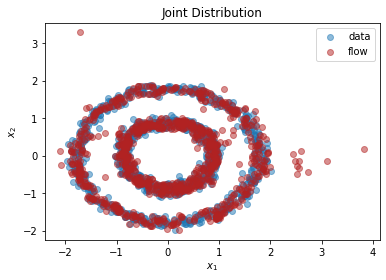

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

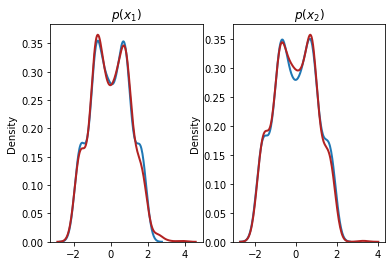

In [19]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True, 
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True, 
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True, 
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True, 
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

We see from the output that this normalizing flow has successfully learnt both the univariate marginals *and* the bivariate distribution.

## Conditional versus Joint Distributions

### Background

In many cases, we wish to represent conditional rather than joint distributions. For instance, in performing variational inference, the variational family is a class of conditional distributions,

$$
\begin{align}
\{q_\psi(\mathbf{z}\mid\mathbf{x})\mid\theta\in\Theta\},
\end{align}
$$

where $\mathbf{z}$ is the latent variable and $\mathbf{x}$ the observed one, that hopefully contains a member close to the true posterior of the model, $p(\mathbf{z}\mid\mathbf{x})$. In other cases, we may wish to learn to generate an object $\mathbf{x}$ conditioned on some context $\mathbf{c}$ using $p_\theta(\mathbf{x}\mid\mathbf{c})$ and observations $\{(\mathbf{x}_n,\mathbf{c}_n)\}^N_{n=1}$. For instance, $\mathbf{x}$ may be a spoken sentence and $\mathbf{c}$ a number of speech features.

The theory of Normalizing Flows is easily generalized to conditional distributions. We denote the variable to condition on by $C=\mathbf{c}\in\mathbb{R}^M$. A simple multivariate source of noise, for example a standard i.i.d. normal distribution, $X\sim\mathcal{N}(\mathbf{0},I_{D\times D})$, is passed through a vector-valued bijection that also conditions on C, $g:\mathbb{R}^D\times\mathbb{R}^M\rightarrow\mathbb{R}^D$, to produce the more complex transformed variable $Y=g(X;C=\mathbf{c})$. In practice, this is usually accomplished by making the parameters for a known normalizing flow bijection $g$ the output of a hypernet neural network that inputs $\mathbf{c}$.

Sampling of conditional transforms simply involves evaluating $Y=g(X; C=\mathbf{c})$. Conditioning the bijections on $\mathbf{c}$, the same formula holds for scoring as for the joint multivariate case.

### Conditional Transforms in Pyro

In Pyro, most learnable transforms have a corresponding conditional version that derives from [ConditionalTransformModule](http://docs.pyro.ai/en/stable/distributions.html#conditionaltransformmodule). For instance, the conditional version of the spline transform is [ConditionalSpline](http://docs.pyro.ai/en/stable/distributions.html#conditionalspline) with helper function [conditional_spline](http://docs.pyro.ai/en/stable/distributions.html#conditional-spline).

In this section, we will show how we can learn our toy dataset as the decomposition of the product of a conditional and a univariate distribution,

$$
\begin{align}
p(x_1,x_2) &= p(x_2\mid x_1)p(x_1).
\end{align}
$$

First, we create the univariate distribution for $x_1$ as shown previously,

In [20]:
dist_base = dist.Normal(torch.zeros(1), torch.ones(1))
x1_transform = T.spline(1)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform])

A conditional transformed distribution is created by passing the base distribution and list of conditional and non-conditional transforms to the [ConditionalTransformedDistribution](http://docs.pyro.ai/en/stable/distributions.html#conditionaltransformeddistribution) class:

In [21]:
x2_transform = T.conditional_spline(1, context_dim=1)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform])

You will notice that we pass the dimension of the context variable, $M=1$, to the conditional spline helper function.

Until we condition on a value of $x_1$, the [ConditionalTransformedDistribution](http://docs.pyro.ai/en/stable/distributions.html#conditionaltransformeddistribution) object is merely a placeholder and cannot be used for sampling or scoring. By calling its [.condition(context)](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.ConditionalDistribution.condition) method, we obtain a [TransformedDistribution](https://pytorch.org/docs/master/distributions.html#transformeddistribution) for which all its conditional transforms have been conditioned on `context`.

For example, to draw a sample from $x_2\mid x_1=1$:

In [22]:
x1 = torch.ones(1)
print(dist_x2_given_x1.condition(x1).sample())

tensor([0.5886])


In general, the context variable may have batch dimensions and these dimensions must broadcast over the batch dimensions of the input variable.

Now, combining the two distributions and training it on the toy dataset:

In [23]:
%%time
steps = 1 if smoke_test else 5001
modules = torch.nn.ModuleList([x1_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)
x1 = dataset[:,0][:,None]
x2 = dataset[:,1][:,None]
for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(x1)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.745392084121704
step: 500, loss: 1.9340037107467651
step: 1000, loss: 1.8142884969711304
step: 1500, loss: 1.7837363481521606
step: 2000, loss: 1.7471681833267212
step: 2500, loss: 1.7265911102294922
step: 3000, loss: 1.7243221998214722
step: 3500, loss: 1.7068430185317993
step: 4000, loss: 1.7039066553115845
step: 4500, loss: 1.6985827684402466
step: 5000, loss: 1.706810474395752
CPU times: user 41.7 s, sys: 862 ms, total: 42.6 s
Wall time: 44 s


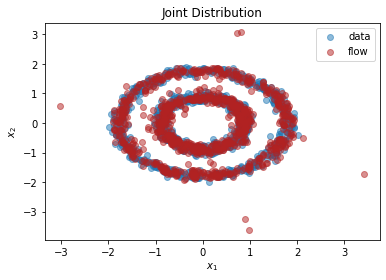

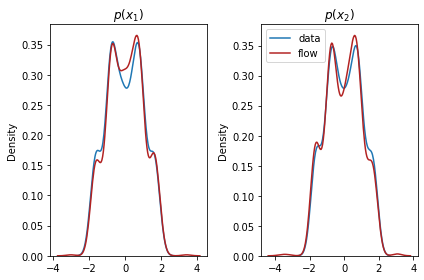

In [36]:
X = torch.cat((x1, x2), dim=-1)
x1_flow = dist_x1.sample(torch.Size([1000,]))
x2_flow = dist_x2_given_x1.condition(x1_flow).sample(torch.Size([1000,]))
X_flow = torch.cat((x1_flow, x2_flow), dim=-1)

plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.kdeplot(X[:,0], label='data')
sns.kdeplot(X_flow[:,0], color='firebrick', label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.kdeplot(X[:,1], label='data')
sns.kdeplot(X_flow[:,1], color='firebrick', label='flow')
plt.legend()
plt.title(r'$p(x_2)$')
plt.tight_layout()
plt.show()

### Conclusions

In this tutorial, we have explained the basic idea behind normalizing flows and the Pyro interface to create flows to represent univariate, multivariate, and conditional distributions. It is useful to think of flows as a powerful general-purpose tool in your probabilistic modelling toolkit, and you can replace any existing distribution in your model with one to increase its flexibility and performance. We hope you have fun exploring the power of normalizing flows!

### References

1. E.G. Tabak, Christina Turner. [*A Family of Nonparametric Density Estimation Algorithms*](https://www.math.nyu.edu/faculty/tabak/publications/Tabak-Turner.pdf). Communications on Pure and Applied Mathematics, 66(2):145–164, 2013.
2. Danilo Jimenez Rezende, Shakir Mohamed. [*Variational Inference with Normalizing Flows*](http://proceedings.mlr.press/v37/rezende15.pdf). ICML 2015.
3. Ivan Kobyzev, Simon J.D. Prince, and Marcus A. Brubaker. [*Normalizing Flows: An Introduction and Review of Current Methods*](https://arxiv.org/abs/1908.09257). \[arXiv:1908.09257\] 2019.
4. George Papamakarios, Eric Nalisnick, Danilo Jimenez Rezende, Shakir Mohamed, Balaji Lakshminarayanan. [*Normalizing Flows for Probabilistic Modeling and Inference*](https://arxiv.org/abs/1912.02762). \[arXiv:1912.02762\] 2019.
5. Conor Durkan, Artur Bekasov, Iain Murray, George Papamakarios. [*Neural Spline Flows*](https://arxiv.org/abs/1906.04032). NeurIPS 2019.
6. Hadi M. Dolatabadi, Sarah Erfani, Christopher Leckie. [*Invertible Generative Modeling using Linear Rational Splines*](https://arxiv.org/abs/2001.05168). AISTATS 2020.
7. James Stewart. [*Calculus*](https://www.stewartcalculus.com/). Cengage Learning. 9th Edition 2020.
8. Laurent Dinh, David Krueger, Yoshua Bengio. [*NICE: Non-linear Independent Components Estimation*](https://arxiv.org/abs/1410.8516). Workshop contribution at ICLR 2015.
9. Laurent Dinh, Jascha Sohl-Dickstein, Samy Bengio. [*Density estimation using Real-NVP*](https://arxiv.org/abs/1605.08803). Conference paper at ICLR 2017.
10. David Ha, Andrew Dai, Quoc V. Le. [*HyperNetworks*](https://arxiv.org/abs/1609.09106). Workshop contribution at ICLR 2017.